In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('2dataset.csv')
data = data.sample(frac=0.2, random_state=42)

In [3]:
class CustomKNN:
    def __init__(self, k, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    
    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = [self._distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

In [4]:
def confusion_matrix_custom(y_true, y_pred):
    TP = sum((t == 1 and p == 1) for t, p in zip(y_true, y_pred))
    TN = sum((t == 0 and p == 0) for t, p in zip(y_true, y_pred))
    FP = sum((t == 0 and p == 1) for t, p in zip(y_true, y_pred))
    FN = sum((t == 1 and p == 0) for t, p in zip(y_true, y_pred))
    return [[TN, FP], [FN, TP]]

def accuracy_custom(y_true, y_pred):
    correct = sum(t == p for t, p in zip(y_true, y_pred))
    total = len(y_true)
    return correct / total if total > 0 else 0

def precision_custom(y_true, y_pred):
    cm = confusion_matrix_custom(y_true, y_pred)
    TP = cm[1][1]
    FP = cm[0][1]
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def recall_custom(y_true, y_pred):
    cm = confusion_matrix_custom(y_true, y_pred)
    TP = cm[1][1]
    FN = cm[1][0]
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def f1_custom(y_true, y_pred):
    precision = precision_custom(y_true, y_pred)
    recall = recall_custom(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [5]:
X = data.drop(columns=['RainTomorrow', 'Date', 'Location'])
y = data['RainTomorrow'].astype(int)

print(y.unique())

[0 1]


In [6]:
model = RandomForestClassifier(random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print("Оценки на каждом фолде:", scores)
print("Средняя точность:", np.mean(scores))
print("Стандартное отклонение:", np.std(scores))

Оценки на каждом фолде: [0.86637931 0.872952   0.86806554 0.87381431 0.86806554]
Средняя точность: 0.8698553389301326
Стандартное отклонение: 0.0029581192007137025


KFold (или StratifiedKFold): Это объект, который задаёт стратегию разбиения данных на k фолдов. Он определяет, как данные будут разделены на обучающие и тестовые подвыборки для каждого из k раундов. StratifiedKFold дополнительно обеспечивает стратификацию (сохранение пропорций классов).

cross_val_score: Это функция, которая автоматизирует процесс кросс-валидации. Она принимает модель, данные, метрику и объект разбиения (например, KFold или StratifiedKFold) и выполняет обучение/оценку модели на каждом фолде, возвращая массив оценок.

Бинарная классификация

In [7]:
y.value_counts()

RainTomorrow
0    14592
1     2804
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
class_distribution = Counter(y)
class_ratio = y.value_counts().max() / y.value_counts().min()
print(class_ratio)

5.203994293865906


In [9]:
# Балансировка классов
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)
y_train_balanced.value_counts()

RainTomorrow
0    11673
1    11673
Name: count, dtype: int64

In [10]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train_balanced)
y_pred_lr = lr.predict(X_test_scaled)
results_lr = {
    'Accuracy': accuracy_custom(y_test, y_pred_lr),
    'Precision': precision_custom(y_test, y_pred_lr),
    'Recall': recall_custom(y_test, y_pred_lr),
    'F1': f1_custom(y_test, y_pred_lr),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_lr)
}
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
results_lr['ROC AUC'] = roc_auc_lr

print(f'Accuracy: {accuracy_custom(y_test, y_pred_lr)}')
print(f'Precision: {precision_custom(y_test, y_pred_lr)}')
print(f'Recall: {recall_custom(y_test, y_pred_lr)}')
print(f'F1: {f1_custom(y_test, y_pred_lr)}')
print(f"ROC AUC: {results_lr['ROC AUC']:.3f}")

Accuracy: 0.7761494252873563
Precision: 0.39579349904397704
Recall: 0.7379679144385026
F1: 0.5152457996266334
ROC AUC: 0.843


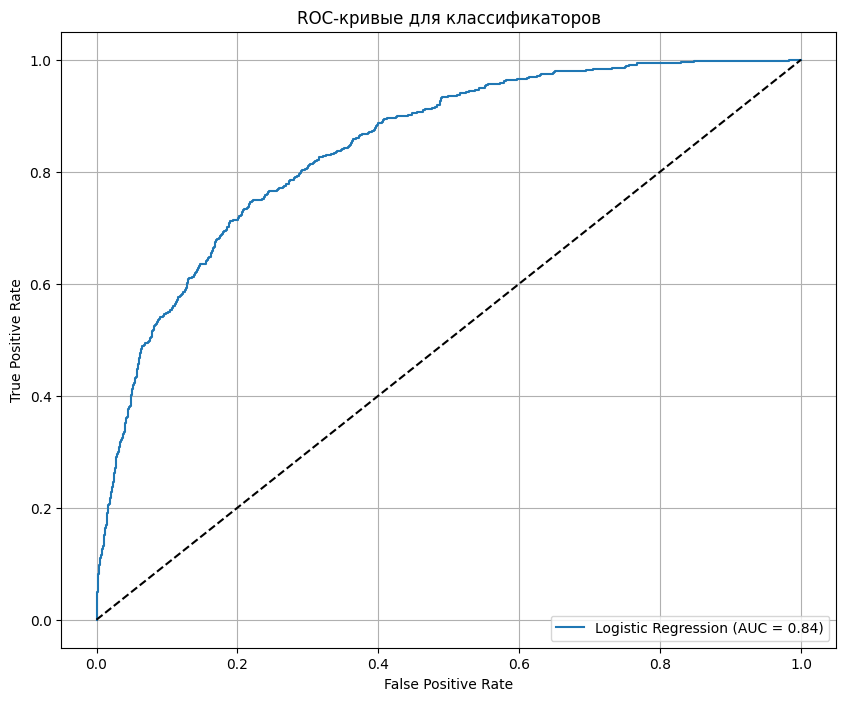

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

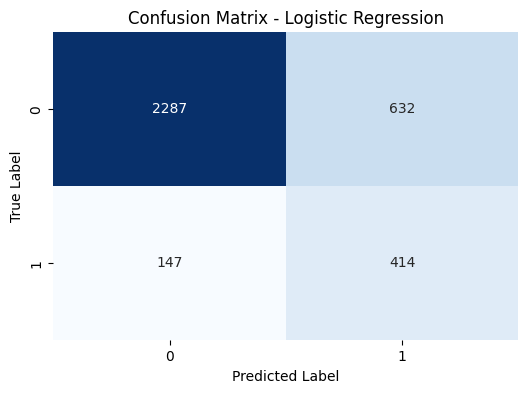

In [12]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_lr['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

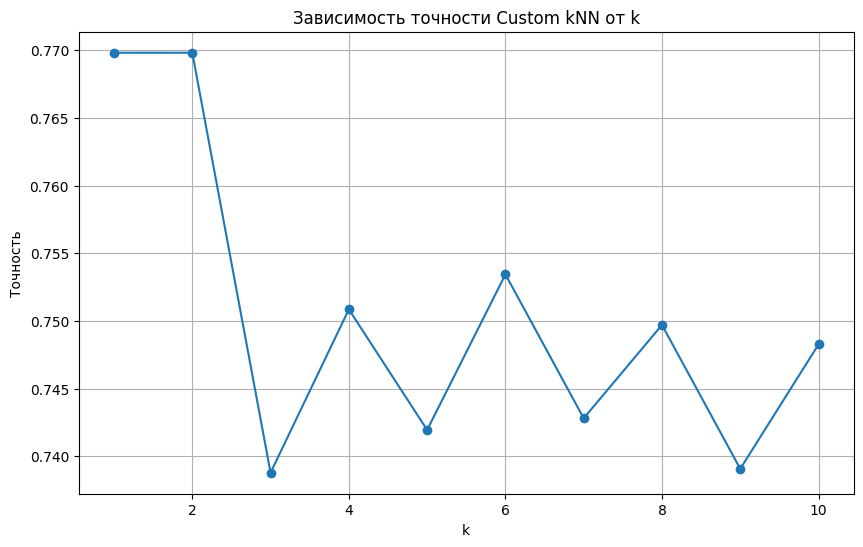

In [13]:
k_values = range(1, 11)
knn_accuracies = []

for k in k_values:
    knn = CustomKNN(k=k, distance_metric='euclidean')
    knn.fit(X_train_scaled, y_train_balanced)
    y_pred_knn = knn.predict(X_test_scaled)
    accuracy = accuracy_custom(y_test, y_pred_knn)
    knn_accuracies.append(accuracy)
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Точность')
plt.title('Зависимость точности Custom kNN от k')
plt.grid(True)
plt.show()

In [14]:
knn = CustomKNN(k=2, distance_metric='euclidean')
knn.fit(X_train_scaled, y_train_balanced)
y_pred_knn = knn.predict(X_test_scaled)
results_knn = {
    'Accuracy': accuracy_custom(y_test, y_pred_knn),
    'Precision': precision_custom(y_test, y_pred_knn),
    'Recall': recall_custom(y_test, y_pred_knn),
    'F1': f1_custom(y_test, y_pred_knn),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_knn)
}
y_prob_knn = knn.predict(X_test_scaled)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
results_knn['ROC AUC'] = roc_auc_knn

print(f'Accuracy: {accuracy_custom(y_test, y_pred_knn)}')
print(f'Precision: {precision_custom(y_test, y_pred_knn)}')
print(f'Recall: {recall_custom(y_test, y_pred_knn)}')
print(f'F1: {f1_custom(y_test, y_pred_knn)}')
print(f"ROC AUC: {results_knn['ROC AUC']:.3f}")

Accuracy: 0.7698275862068965
Precision: 0.35037406483790523
Recall: 0.5008912655971479
F1: 0.41232575201760824
ROC AUC: 0.661


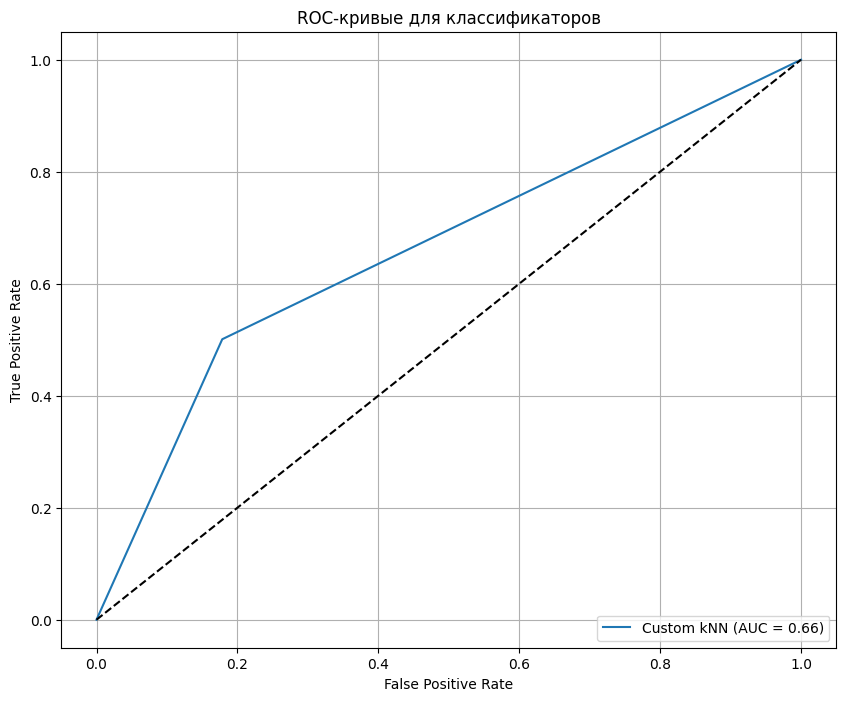

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, label=f'Custom kNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

При k = 1 и k = 2 точность высокая (около 0.75). При малых k модель сильно подстраивается под ближайшие точки, что может хорошо работать, если данные имеют четкие границы классов, но это также может приводить к переобучению. Резкое падение при k = 3: Точность падает до ~0.725. Возможно, увеличение k добавляет "шумные" или менее релевантные точки в принятие решения, что ухудшает классификацию. Это может быть связано с особенностями данных. Колебания при k от 4 до 10: Точность колеблется между ~0.71 и ~0.73. При увеличении k модель становится более устойчивой к шуму, но может терять локальную структуру данных, что приводит к нестабильным результатам. Колебания могут быть вызваны случайностью в данных.
Общий тренд: После k = 3 точность не возвращается к исходному высокому значению, что может указывать на то, что большие значения k не подходят для этих данных — модель становится слишком "гладкой" и теряет способность хорошо разделять классы.

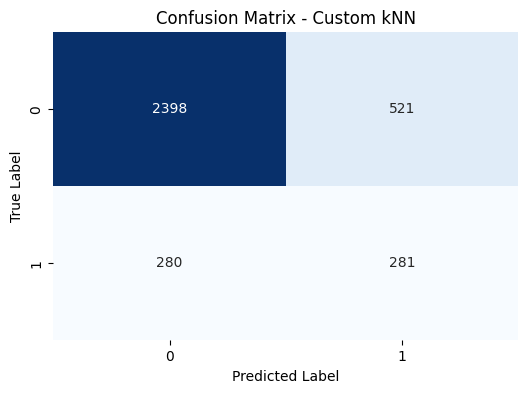

In [16]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_knn['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Custom kNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train_balanced)
y_pred_nb = nb.predict(X_test_scaled)
results_nb = {
    'Accuracy': accuracy_custom(y_test, y_pred_nb),
    'Precision': precision_custom(y_test, y_pred_nb),
    'Recall': recall_custom(y_test, y_pred_nb),
    'F1': f1_custom(y_test, y_pred_nb),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_nb)
}
y_prob_nb = nb.predict_proba(X_test_scaled)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
results_nb['ROC AUC'] = roc_auc_nb

print(f'Accuracy: {accuracy_custom(y_test, y_pred_nb)}')
print(f'Precision: {precision_custom(y_test, y_pred_nb)}')
print(f'Recall: {recall_custom(y_test, y_pred_nb)}')
print(f'F1: {f1_custom(y_test, y_pred_nb)}')
print(f"ROC AUC: {results_nb['ROC AUC']:.3f}")

Accuracy: 0.757183908045977
Precision: 0.3657844990548204
Recall: 0.6898395721925134
F1: 0.47807288449660285
ROC AUC: 0.797


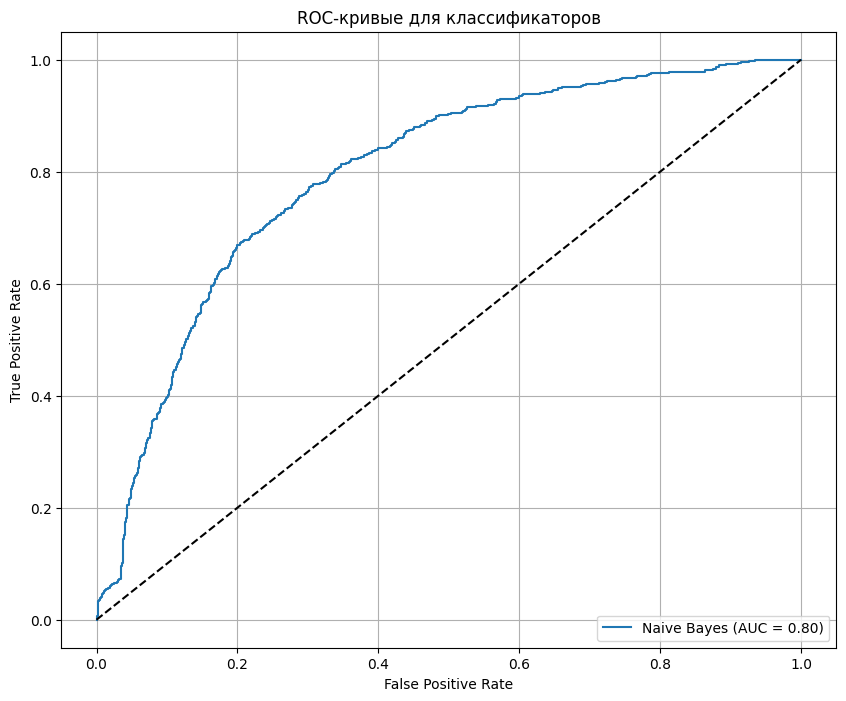

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

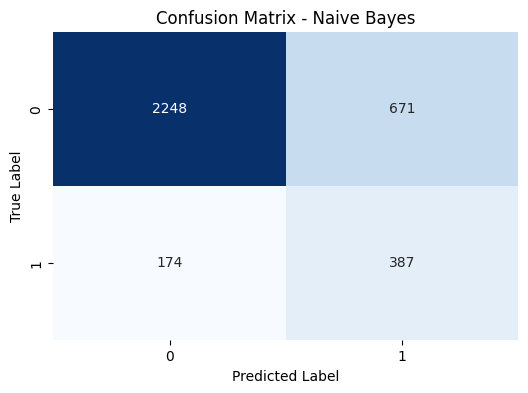

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_nb['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_scaled, y_train_balanced)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)
results_svm_linear = {
    'Accuracy': accuracy_custom(y_test, y_pred_svm_linear),
    'Precision': precision_custom(y_test, y_pred_svm_linear),
    'Recall': recall_custom(y_test, y_pred_svm_linear),
    'F1': f1_custom(y_test, y_pred_svm_linear),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_svm_linear)
}
y_prob_svm_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]
fpr_svm_linear, tpr_svm_linear, _ = roc_curve(y_test, y_prob_svm_linear)
roc_auc_svm_linear = auc(fpr_svm_linear, tpr_svm_linear)
results_svm_linear['ROC AUC'] = roc_auc_svm_linear

print(f'Accuracy: {accuracy_custom(y_test, y_pred_svm_linear)}')
print(f'Precision: {precision_custom(y_test, y_pred_svm_linear)}')
print(f'Recall: {recall_custom(y_test, y_pred_svm_linear)}')
print(f'F1: {f1_custom(y_test, y_pred_svm_linear)}')
print(f"ROC AUC: {results_svm_linear['ROC AUC']:.3f}")

Accuracy: 0.771551724137931
Precision: 0.3902439024390244
Recall: 0.7415329768270945
F1: 0.5113706207744315
ROC AUC: 0.842


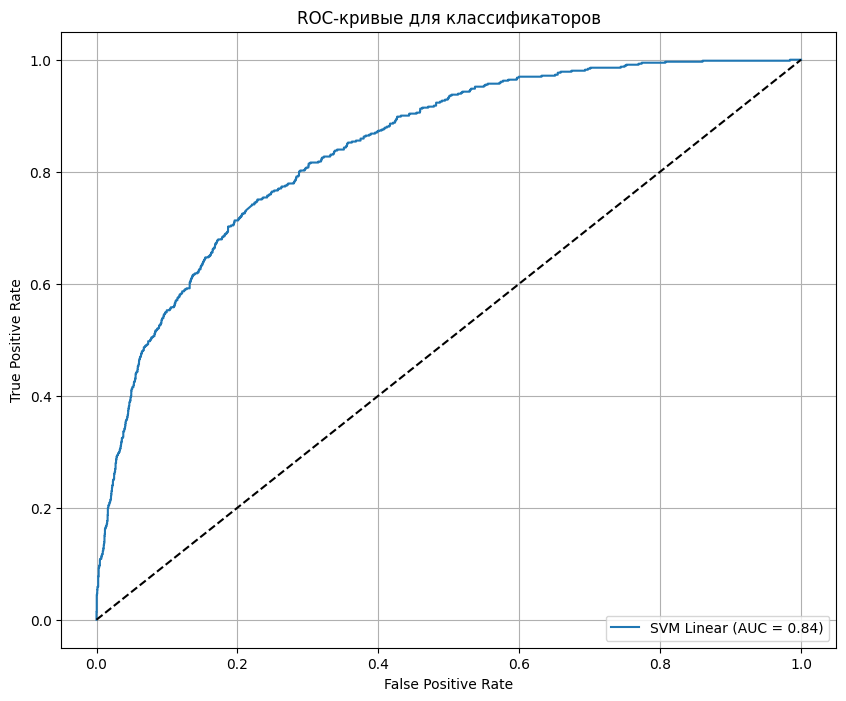

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm_linear, tpr_svm_linear, label=f'SVM Linear (AUC = {roc_auc_svm_linear:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

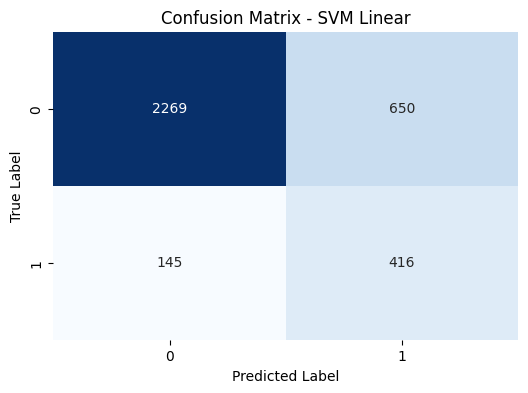

In [22]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_svm_linear['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM Linear')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
svm_poly = SVC(kernel='poly', degree=3, probability=True, random_state=42)
svm_poly.fit(X_train_scaled, y_train_balanced)
y_pred_svm_poly = svm_poly.predict(X_test_scaled)
results_svm_poly = {
    'Accuracy': accuracy_custom(y_test, y_pred_svm_poly),
    'Precision': precision_custom(y_test, y_pred_svm_poly),
    'Recall': recall_custom(y_test, y_pred_svm_poly),
    'F1': f1_custom(y_test, y_pred_svm_poly),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_svm_poly)
}
y_prob_svm_poly = svm_poly.predict_proba(X_test_scaled)[:, 1]
fpr_svm_poly, tpr_svm_poly, _ = roc_curve(y_test, y_prob_svm_poly)
roc_auc_svm_poly = auc(fpr_svm_poly, tpr_svm_poly)
results_svm_poly['ROC AUC'] = roc_auc_svm_poly

print(f'Accuracy: {accuracy_custom(y_test, y_pred_svm_poly)}')
print(f'Precision: {precision_custom(y_test, y_pred_svm_poly)}')
print(f'Recall: {recall_custom(y_test, y_pred_svm_poly)}')
print(f'F1: {f1_custom(y_test, y_pred_svm_poly)}')
print(f"ROC AUC: {results_svm_poly['ROC AUC']:.3f}")

Accuracy: 0.792816091954023
Precision: 0.41416309012875535
Recall: 0.6880570409982175
F1: 0.5170797052913597
ROC AUC: 0.821


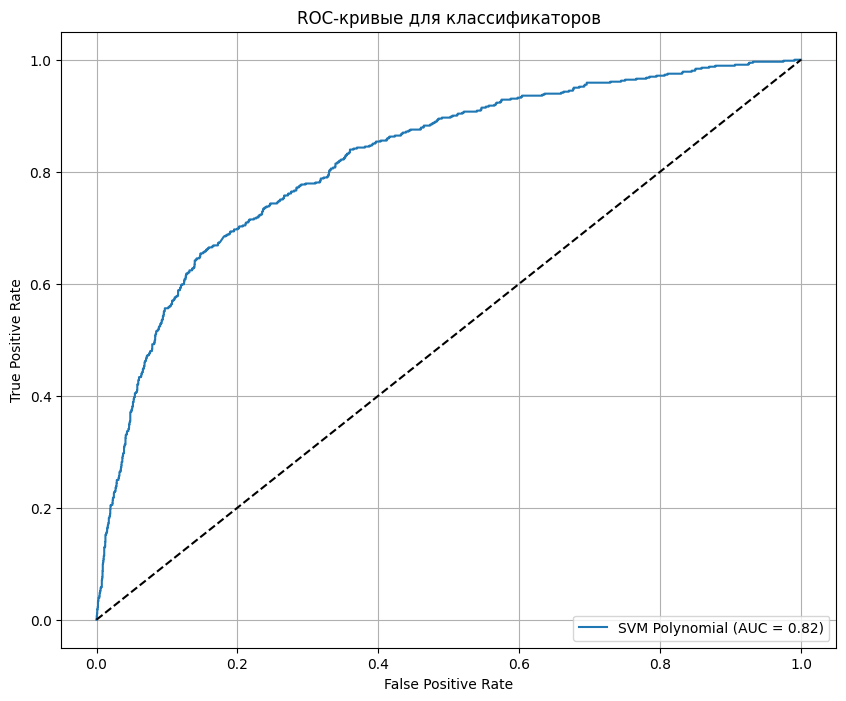

In [24]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm_poly, tpr_svm_poly, label=f'SVM Polynomial (AUC = {roc_auc_svm_poly:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

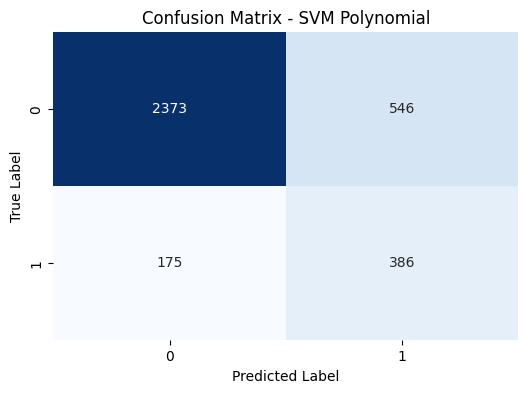

In [25]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_svm_poly['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM Polynomial')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train_balanced)
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)
results_svm_rbf = {
    'Accuracy': accuracy_custom(y_test, y_pred_svm_rbf),
    'Precision': precision_custom(y_test, y_pred_svm_rbf),
    'Recall': recall_custom(y_test, y_pred_svm_rbf),
    'F1': f1_custom(y_test, y_pred_svm_rbf),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_svm_rbf)
}
y_prob_svm_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, y_prob_svm_rbf)
roc_auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)
results_svm_rbf['ROC AUC'] = roc_auc_svm_rbf

print(f'Accuracy: {accuracy_custom(y_test, y_pred_svm_rbf)}')
print(f'Precision: {precision_custom(y_test, y_pred_svm_rbf)}')
print(f'Recall: {recall_custom(y_test, y_pred_svm_rbf)}')
print(f'F1: {f1_custom(y_test, y_pred_svm_rbf)}')
print(f"ROC AUC: {results_svm_rbf['ROC AUC']:.3f}")

Accuracy: 0.8146551724137931
Precision: 0.4492753623188406
Recall: 0.6631016042780749
F1: 0.5356371490280777
ROC AUC: 0.845


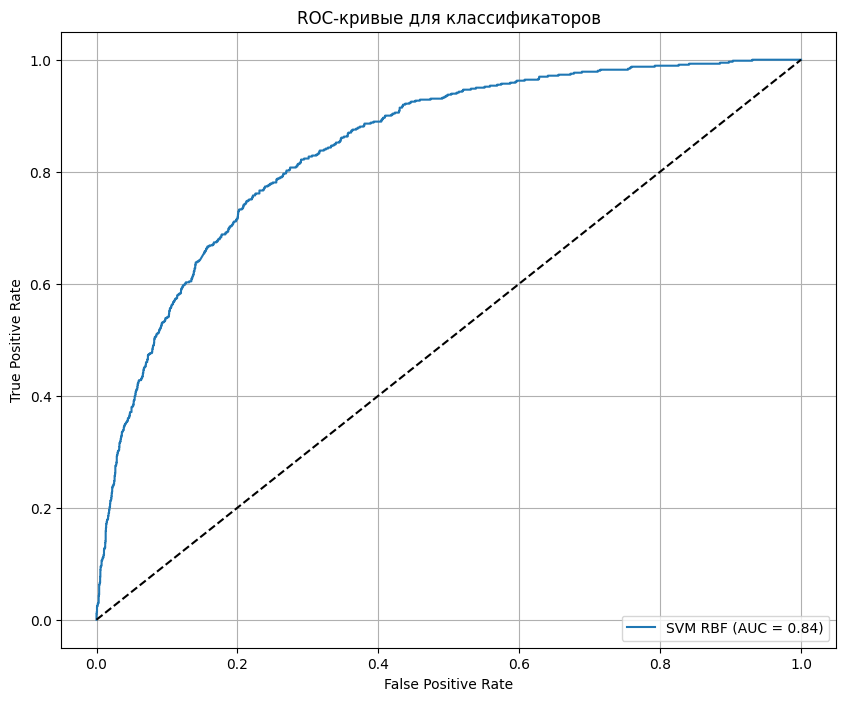

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f'SVM RBF (AUC = {roc_auc_svm_rbf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

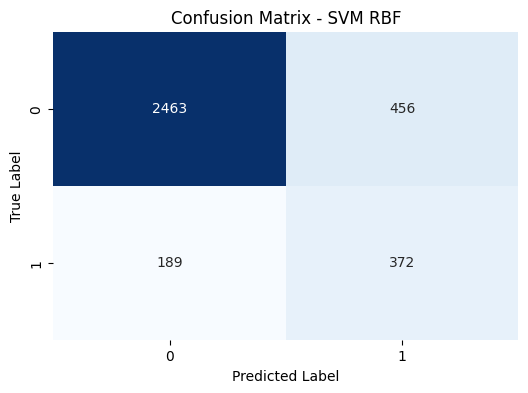

In [28]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_svm_rbf['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM RBF')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
svm_sigmoid = SVC(kernel='sigmoid', probability=True, random_state=42)
svm_sigmoid.fit(X_train_scaled, y_train_balanced)
y_pred_svm_sigmoid = svm_sigmoid.predict(X_test_scaled)
results_svm_sigmoid = {
    'Accuracy': accuracy_custom(y_test, y_pred_svm_sigmoid),
    'Precision': precision_custom(y_test, y_pred_svm_sigmoid),
    'Recall': recall_custom(y_test, y_pred_svm_sigmoid),
    'F1': f1_custom(y_test, y_pred_svm_sigmoid),
    'Confusion Matrix': confusion_matrix_custom(y_test, y_pred_svm_sigmoid)
}
y_prob_svm_sigmoid = svm_sigmoid.predict_proba(X_test_scaled)[:, 1]
fpr_svm_sigmoid, tpr_svm_sigmoid, _ = roc_curve(y_test, y_prob_svm_sigmoid)
roc_auc_svm_sigmoid = auc(fpr_svm_sigmoid, tpr_svm_sigmoid)
results_svm_sigmoid['ROC AUC'] = roc_auc_svm_sigmoid

print(f'Accuracy: {accuracy_custom(y_test, y_pred_svm_sigmoid)}')
print(f'Precision: {precision_custom(y_test, y_pred_svm_sigmoid)}')
print(f'Recall: {recall_custom(y_test, y_pred_svm_sigmoid)}')
print(f'F1: {f1_custom(y_test, y_pred_svm_sigmoid)}')
print(f"ROC AUC: {results_svm_sigmoid['ROC AUC']:.3f}")

Accuracy: 0.6778735632183908
Precision: 0.2862595419847328
Recall: 0.6684491978609626
F1: 0.4008551576696953
ROC AUC: 0.717


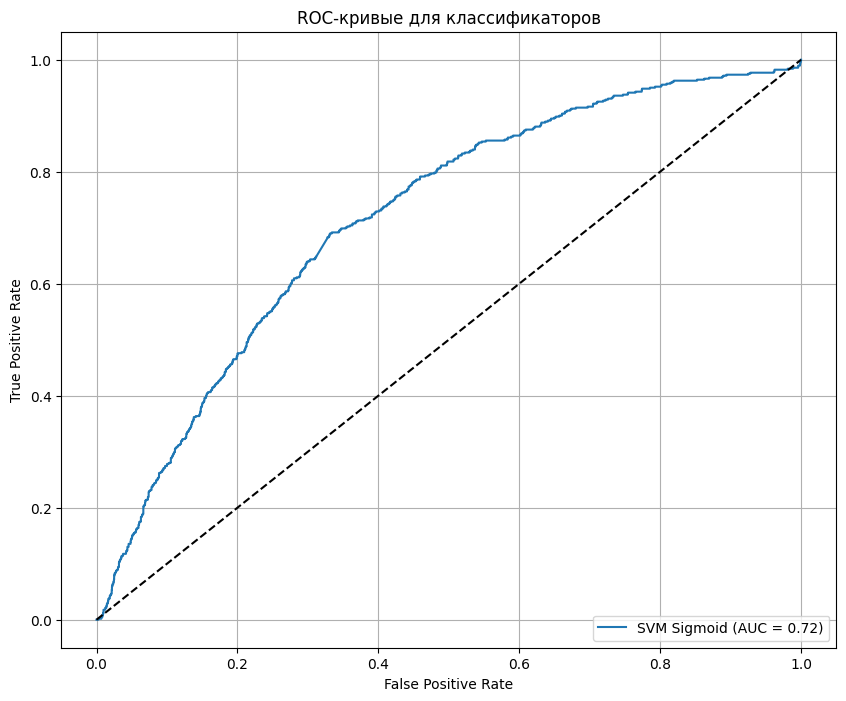

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm_sigmoid, tpr_svm_sigmoid, label=f'SVM Sigmoid (AUC = {roc_auc_svm_sigmoid:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

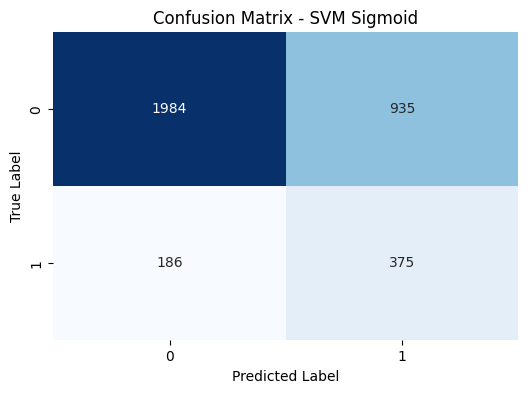

In [31]:
plt.figure(figsize=(6, 4))
sns.heatmap(results_svm_sigmoid['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM Sigmoid')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- **SVM Linear**, по-видимому, является лучшей моделью в целом с наивысшим показателем F1 (0,484), наивысшей полнотой (0,692) и наивысшей ROC AUC (0,798). Она обеспечивает надежный баланс между выявлением истинно положительных результатов (высокая полнота) и общей производительностью.
- **SVM RBF** является сильной альтернативой, если приоритетами являются точность (0,377) и минимизация ложных положительных результатов (FP: 101), поскольку она также имеет наивысшую точность (0,775).
- **Logistic Regression** является близким конкурентом с сильными метриками по всем направлениям (F1: 0,475, ROC AUC: 0,797) и может быть предпочтительнее для интерпретируемости.